# First Test Basic VaR Models 

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np

# Import functions
import basic_var 
import backtesting as BT
import plots 
import expected_shortfall as ES

### Data

In [10]:
# Download data
sp500_data = yf.download("^GSPC", start="2017-01-01", end="2021-01-01")
sp500_data["Log Returns"] = np.log(sp500_data["Close"] / sp500_data["Close"].shift(1))
returns = sp500_data["Log Returns"].dropna()

[*********************100%***********************]  1 of 1 completed


In [11]:
# Set parameters
confidence_level = 0.99 # <----- Can choose 0.95 etc

### Historical VaR

Historical VaR estimate (abs): 3.81%
Full Period — Violations: 11, Rate: 1.09%
Historical ES estimate (abs): 6.23%



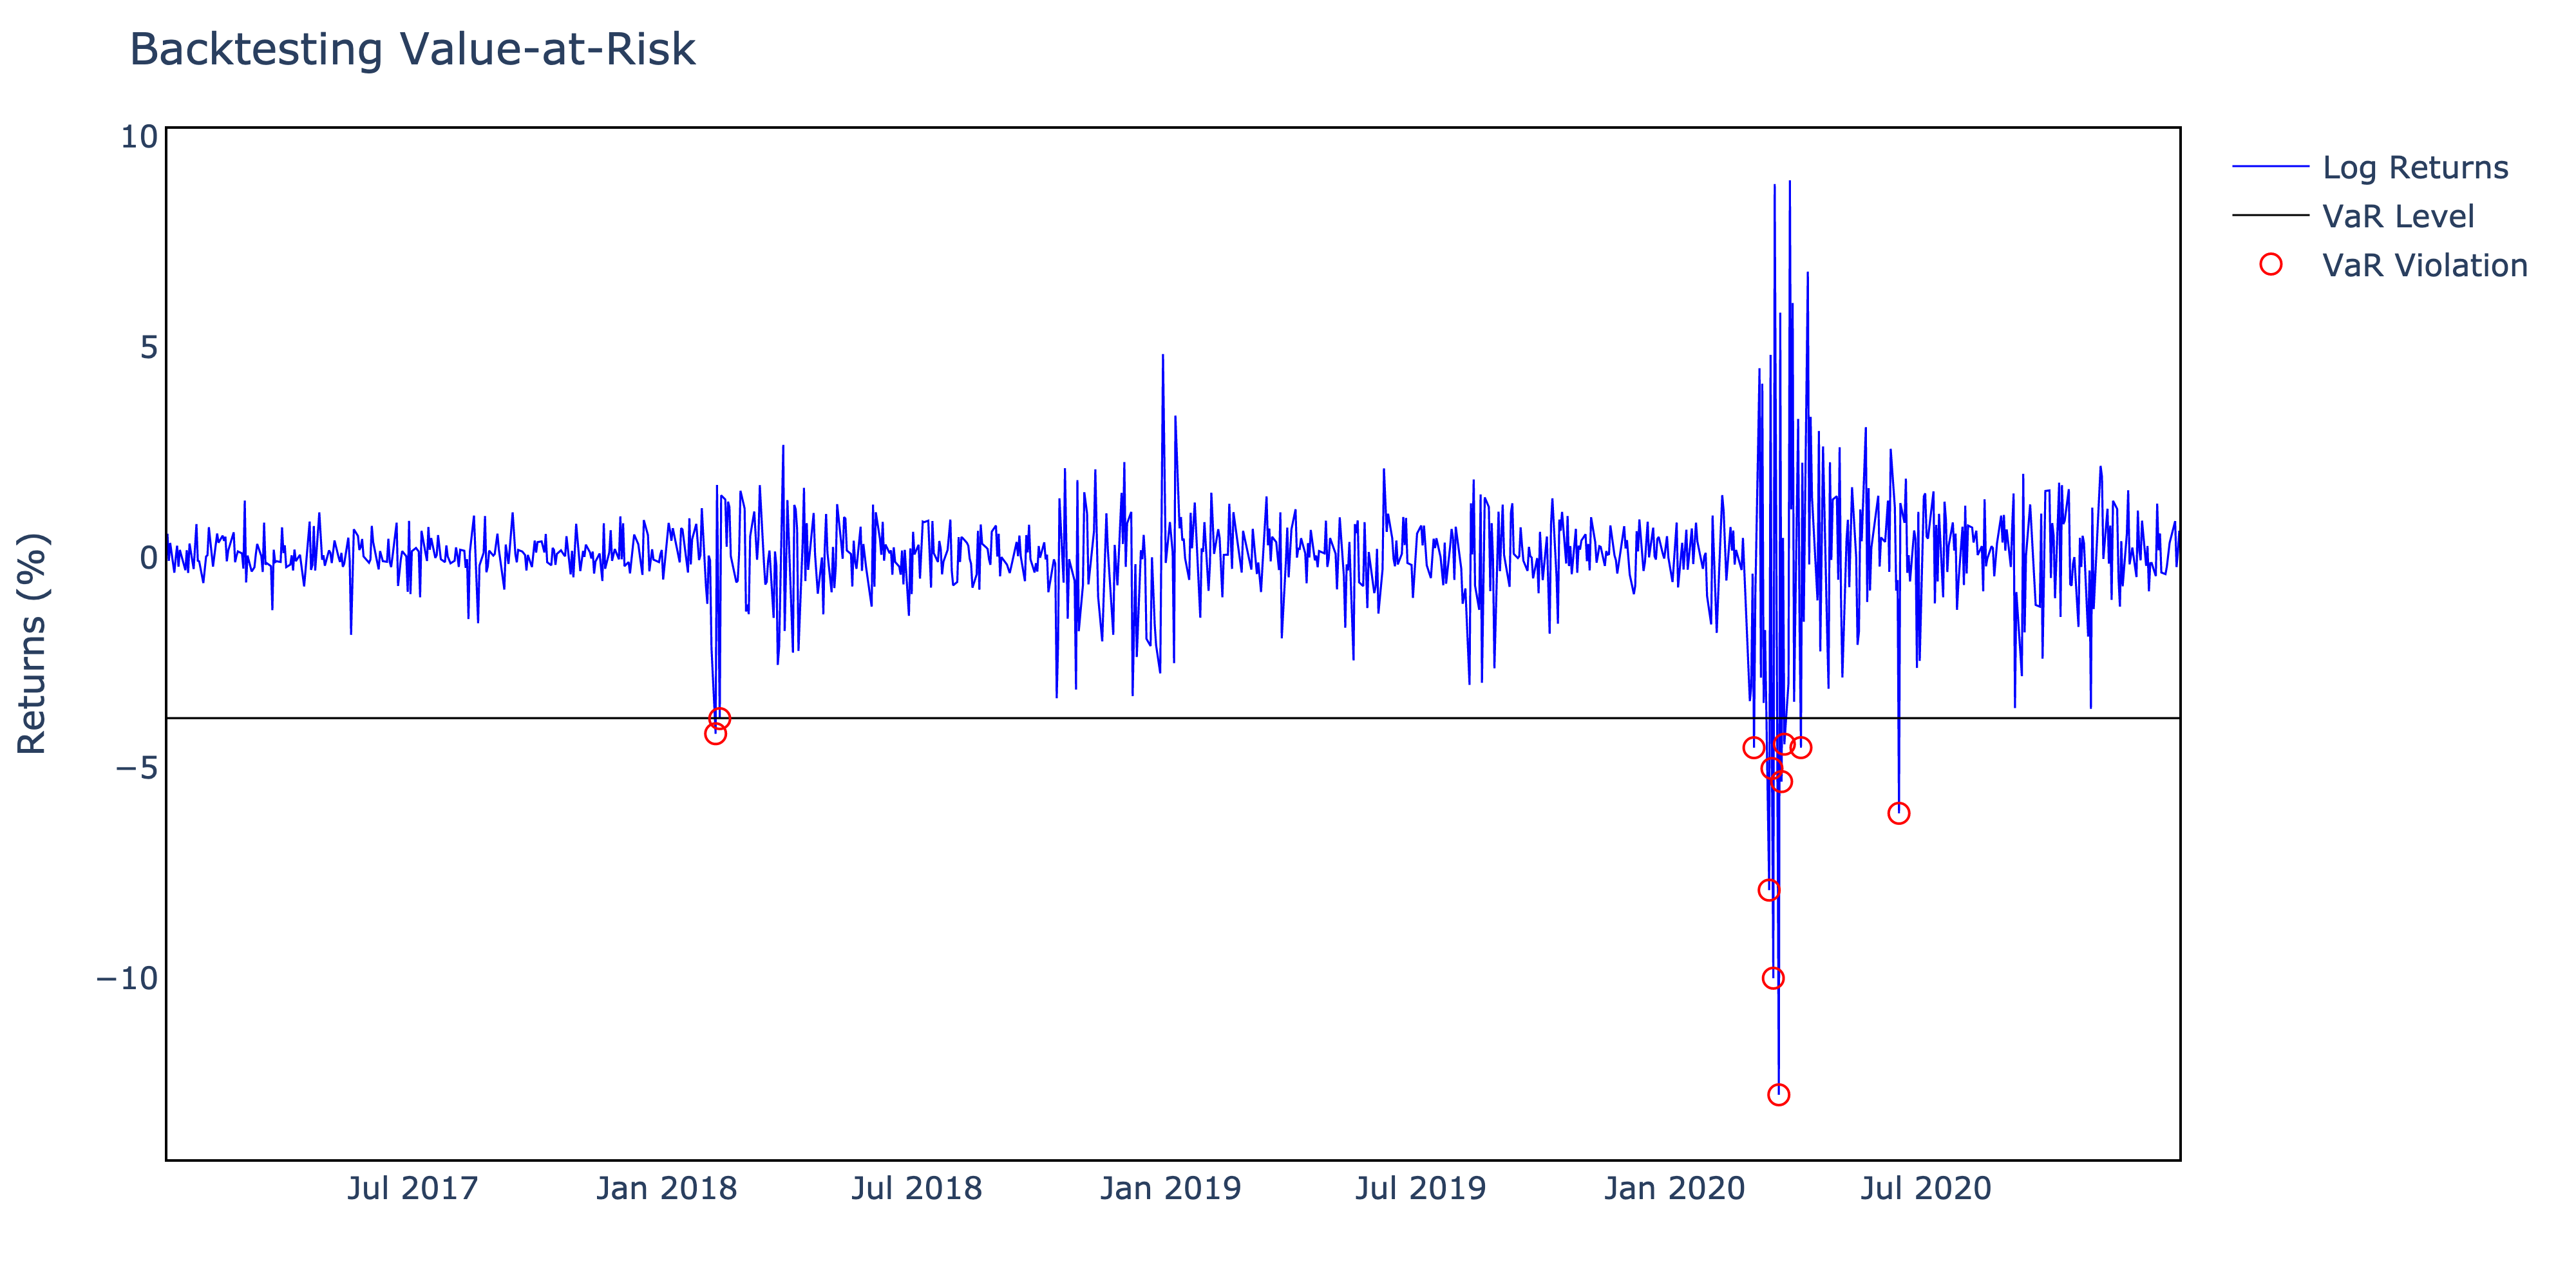


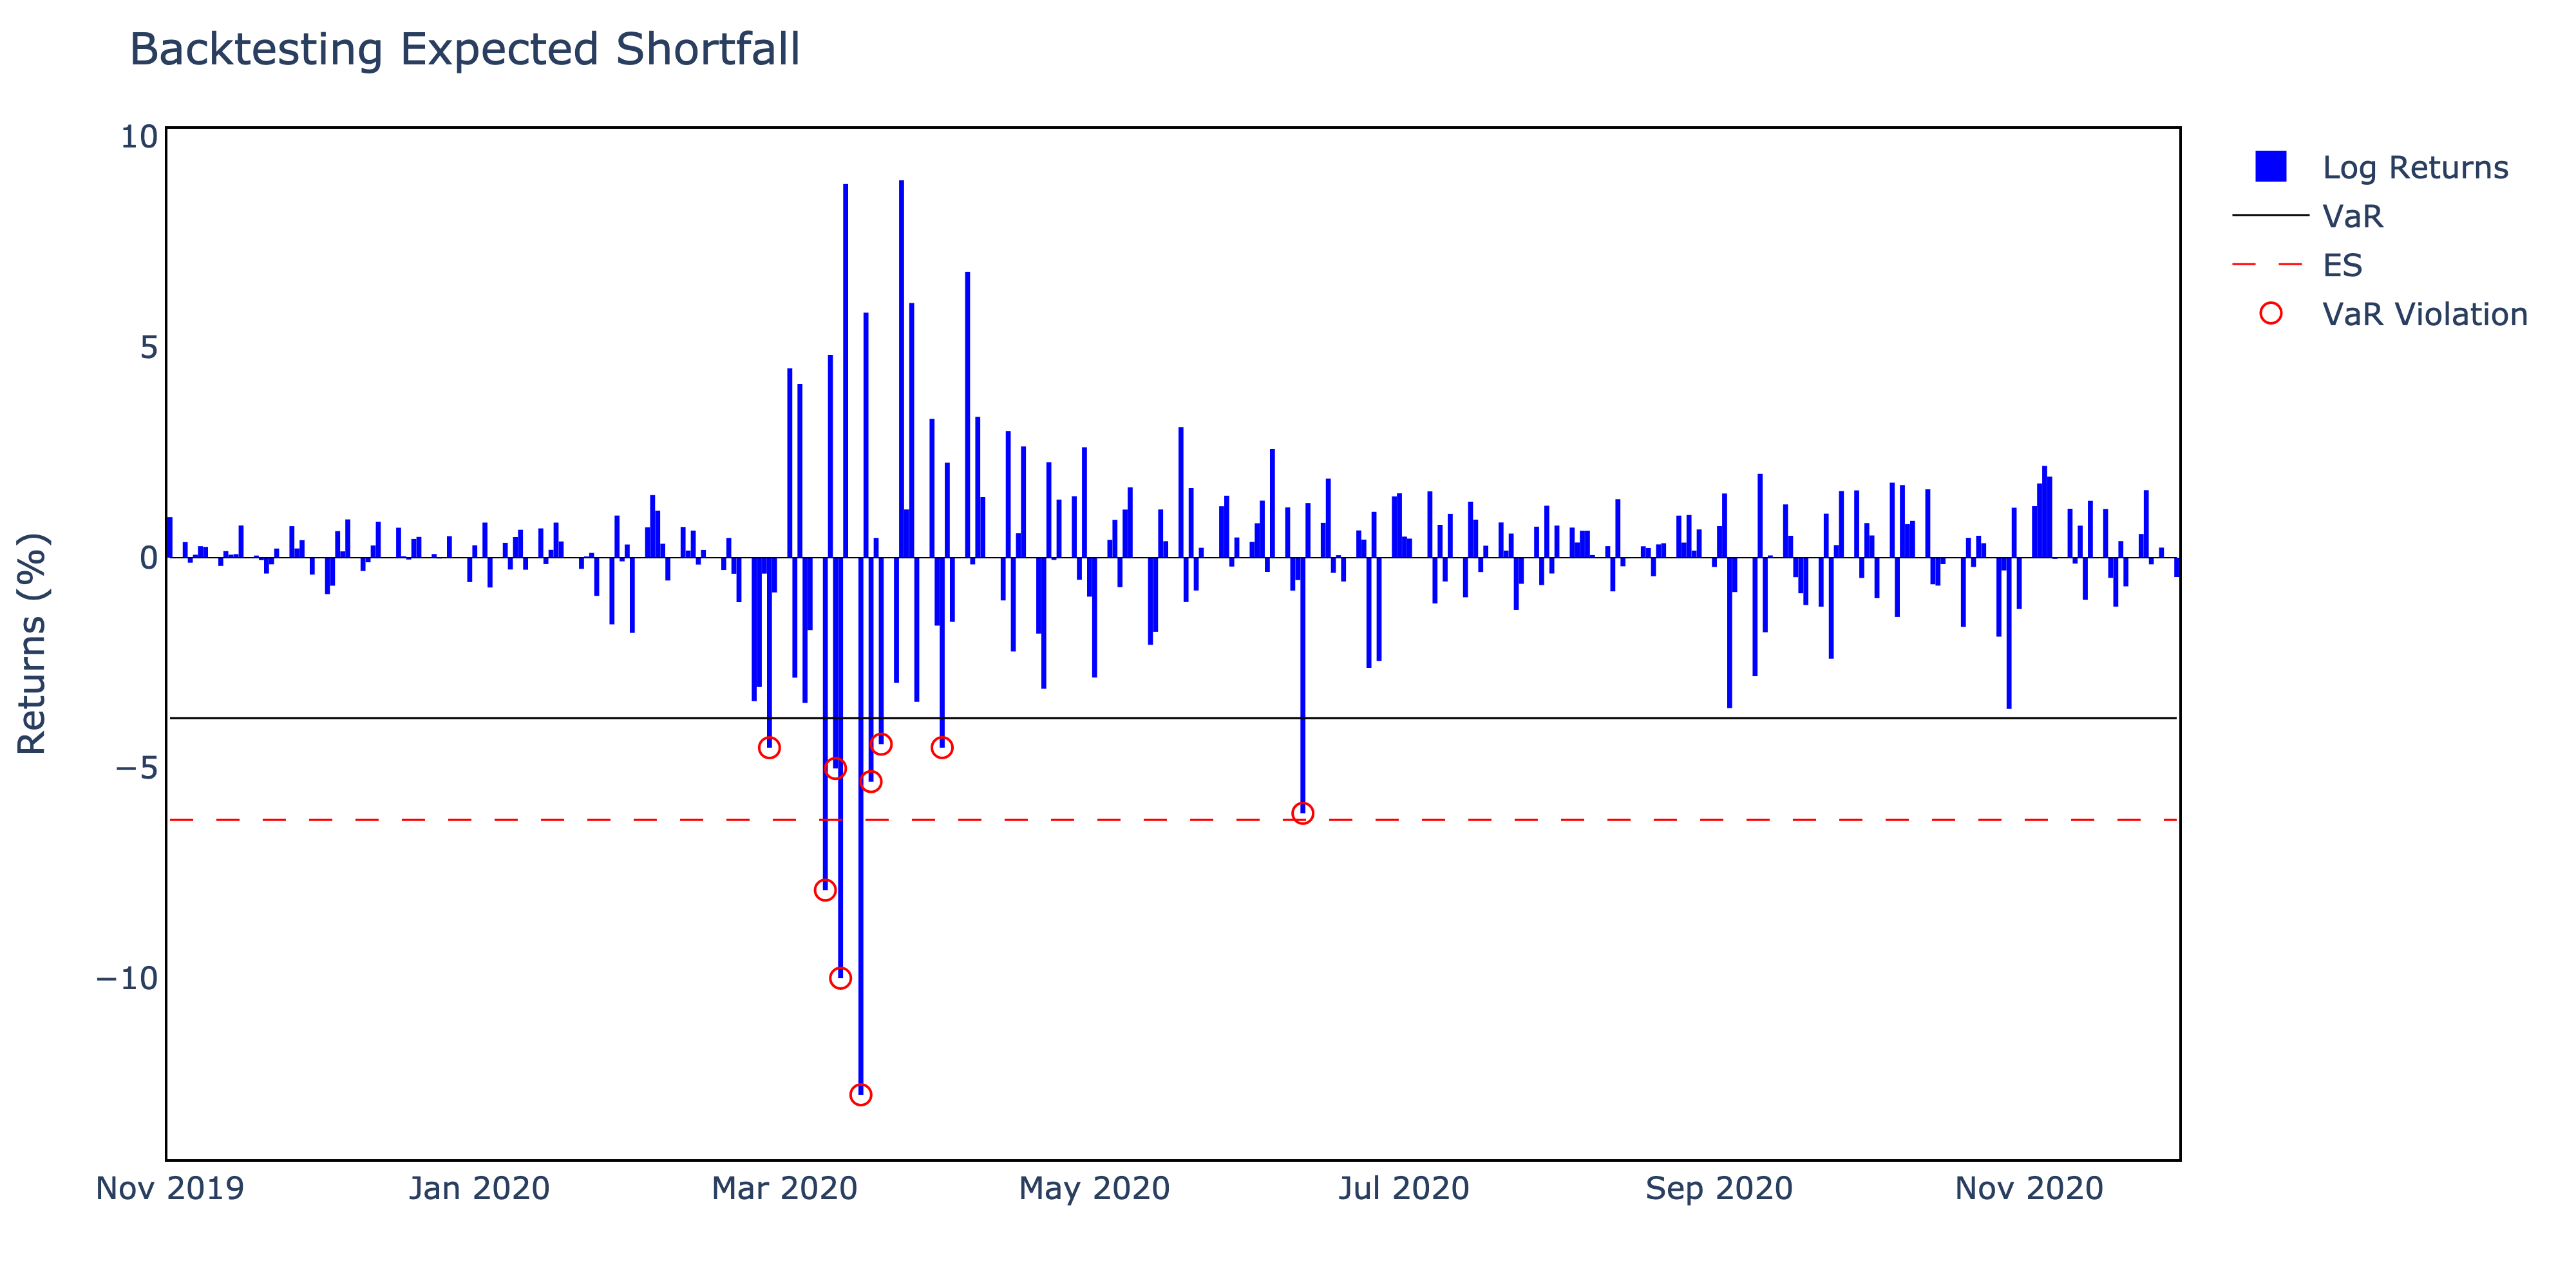

In [12]:
# Apply Historical VaR model
historical_output, var = basic_var.var_historical(returns, confidence_level)

print(f"Historical VaR estimate (abs): {var:.2f}%")

# Backtest full period
violations, rate = BT.backtest_var(historical_output, confidence_level)
print(f"Full Period — Violations: {violations}, Rate: {rate:.2f}%")

# Compute ES for the whole period
historical_output, es_estimate = ES.compute_es_historical(historical_output, confidence_level)

print(f"Historical ES estimate (abs): {100 * es_estimate:.2f}%")

# Plot interactive VaR
fig_var = plots.plot_var(historical_output, interactive=False)

# Plot interactive ES for a subset
fig_es = plots.plot_es(historical_output, subset=("2019-11-01", "2020-11-30"), interactive=False)


In [13]:
historical_output.head()

,Returns,VaR,VaR Violation,ES
Date,,,,
2017-01-04,0.005706,0.038142,False,0.062312
2017-01-05,-0.000771,0.038142,False,0.062312
2017-01-06,0.003511,0.038142,False,0.062312
2017-01-09,-0.003555,0.038142,False,0.062312
2017-01-10,0.000000,0.038142,False,0.062312


### Parametric VaR

Parametric VaR estimate (abs): 4.04%
Full Period — Violations: 10, Rate: 0.99%
Parametric ES estimate (abs): 8.93%



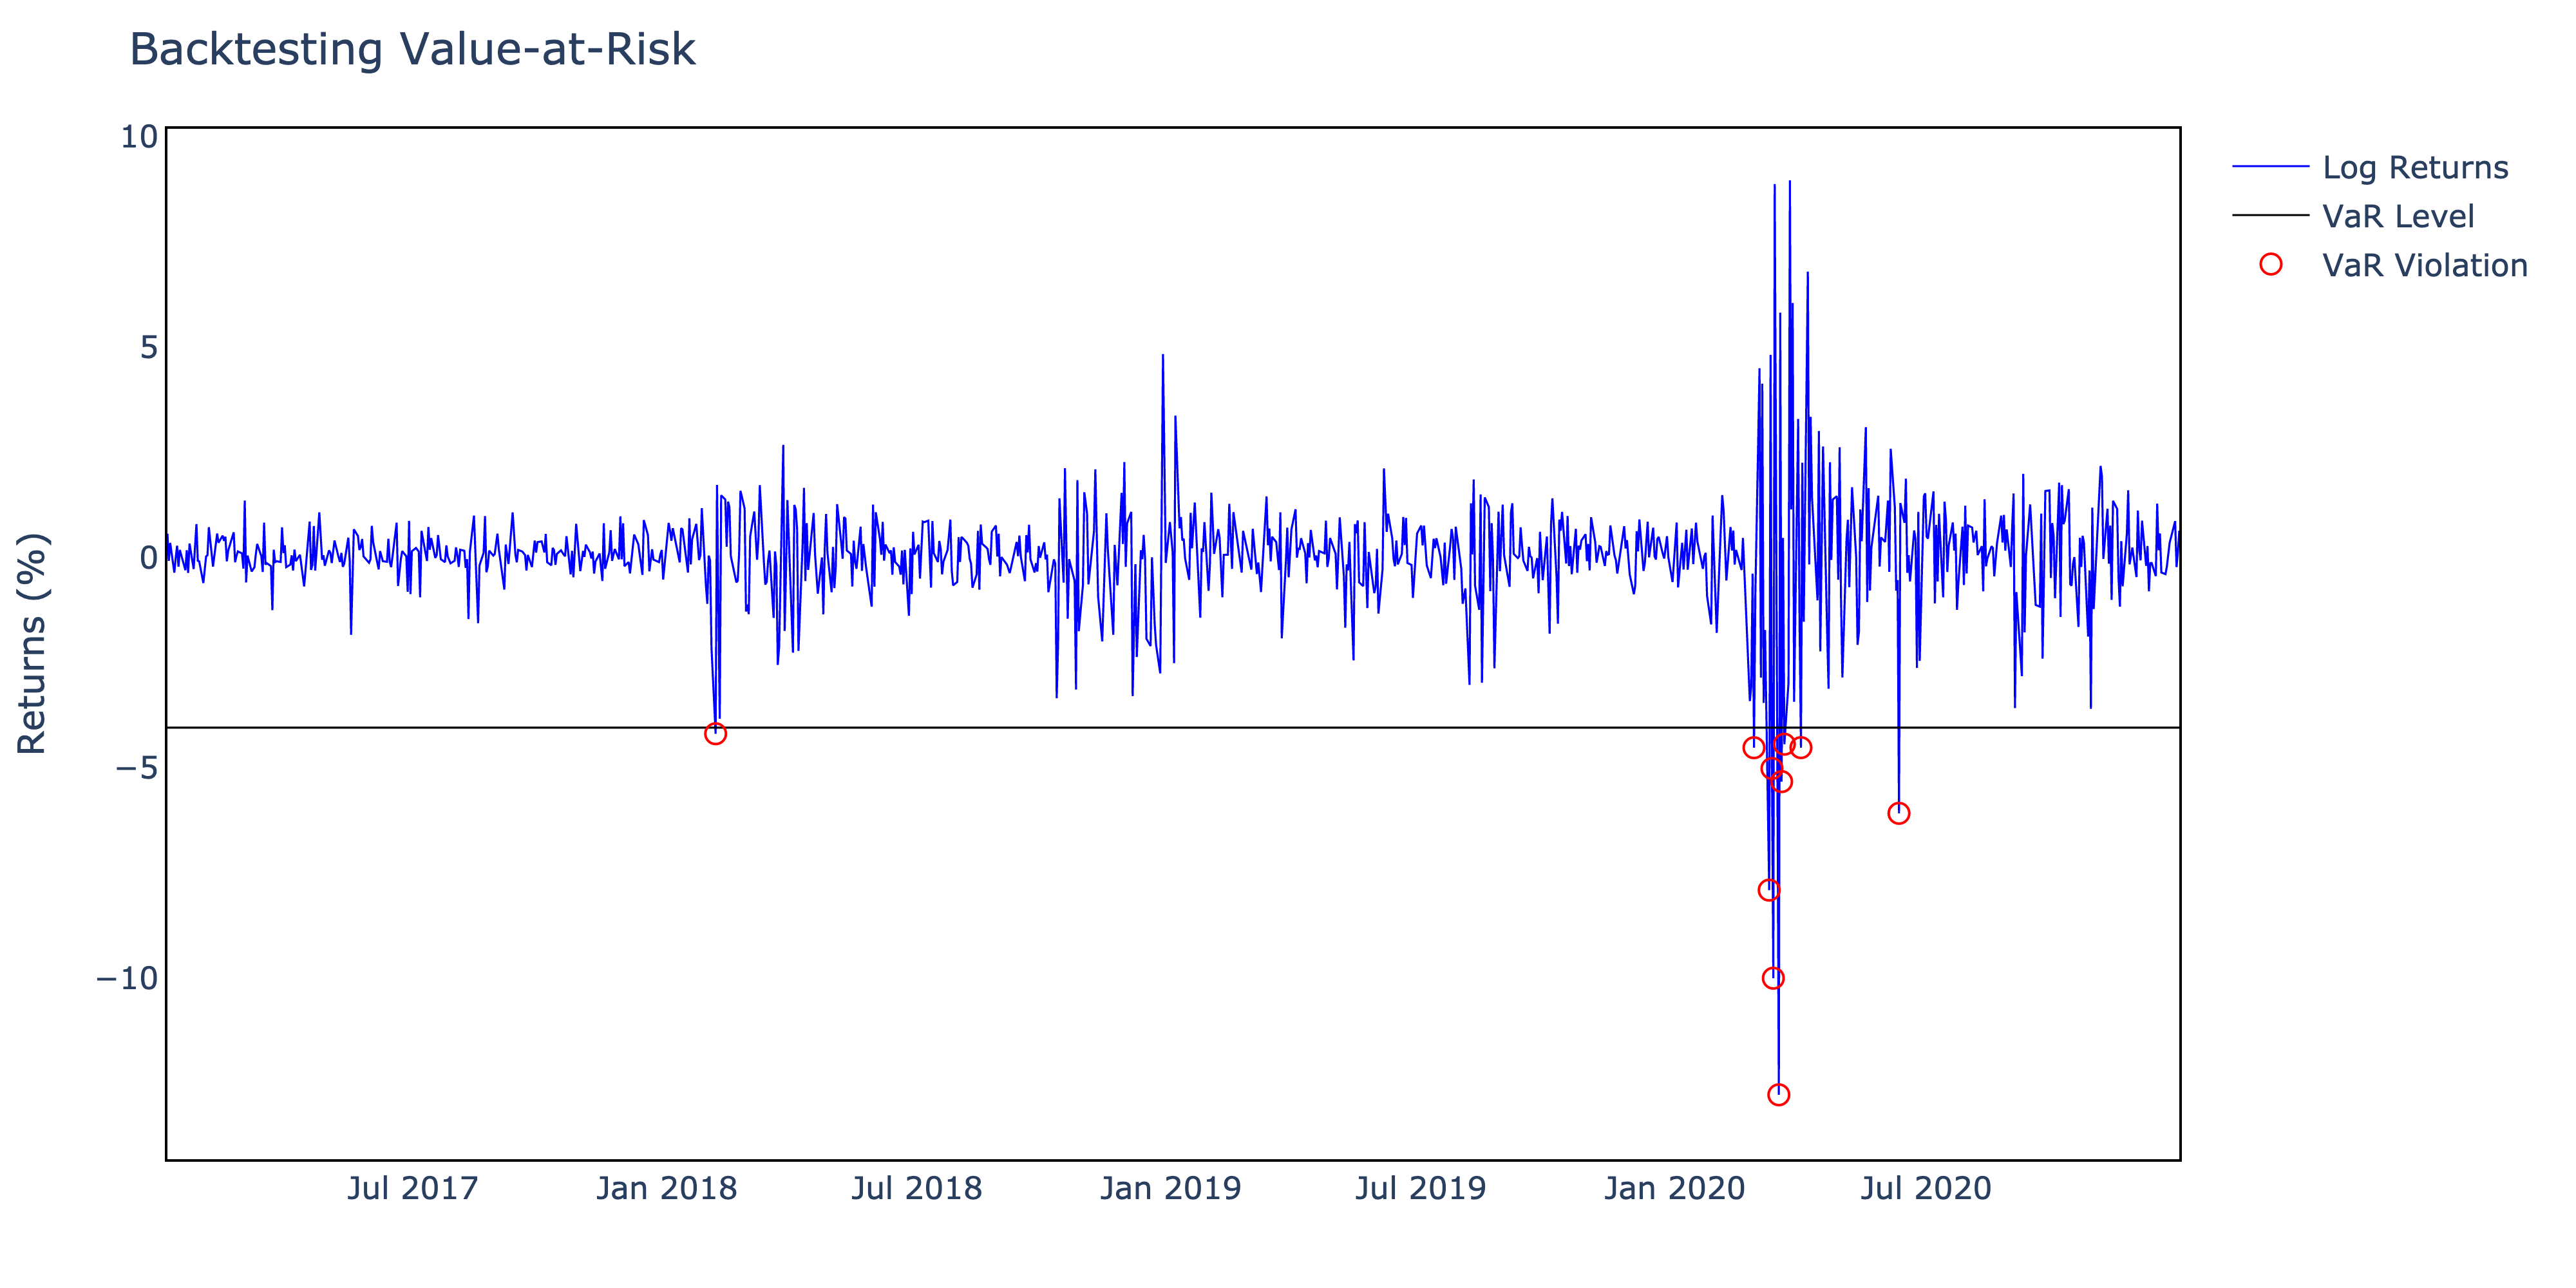


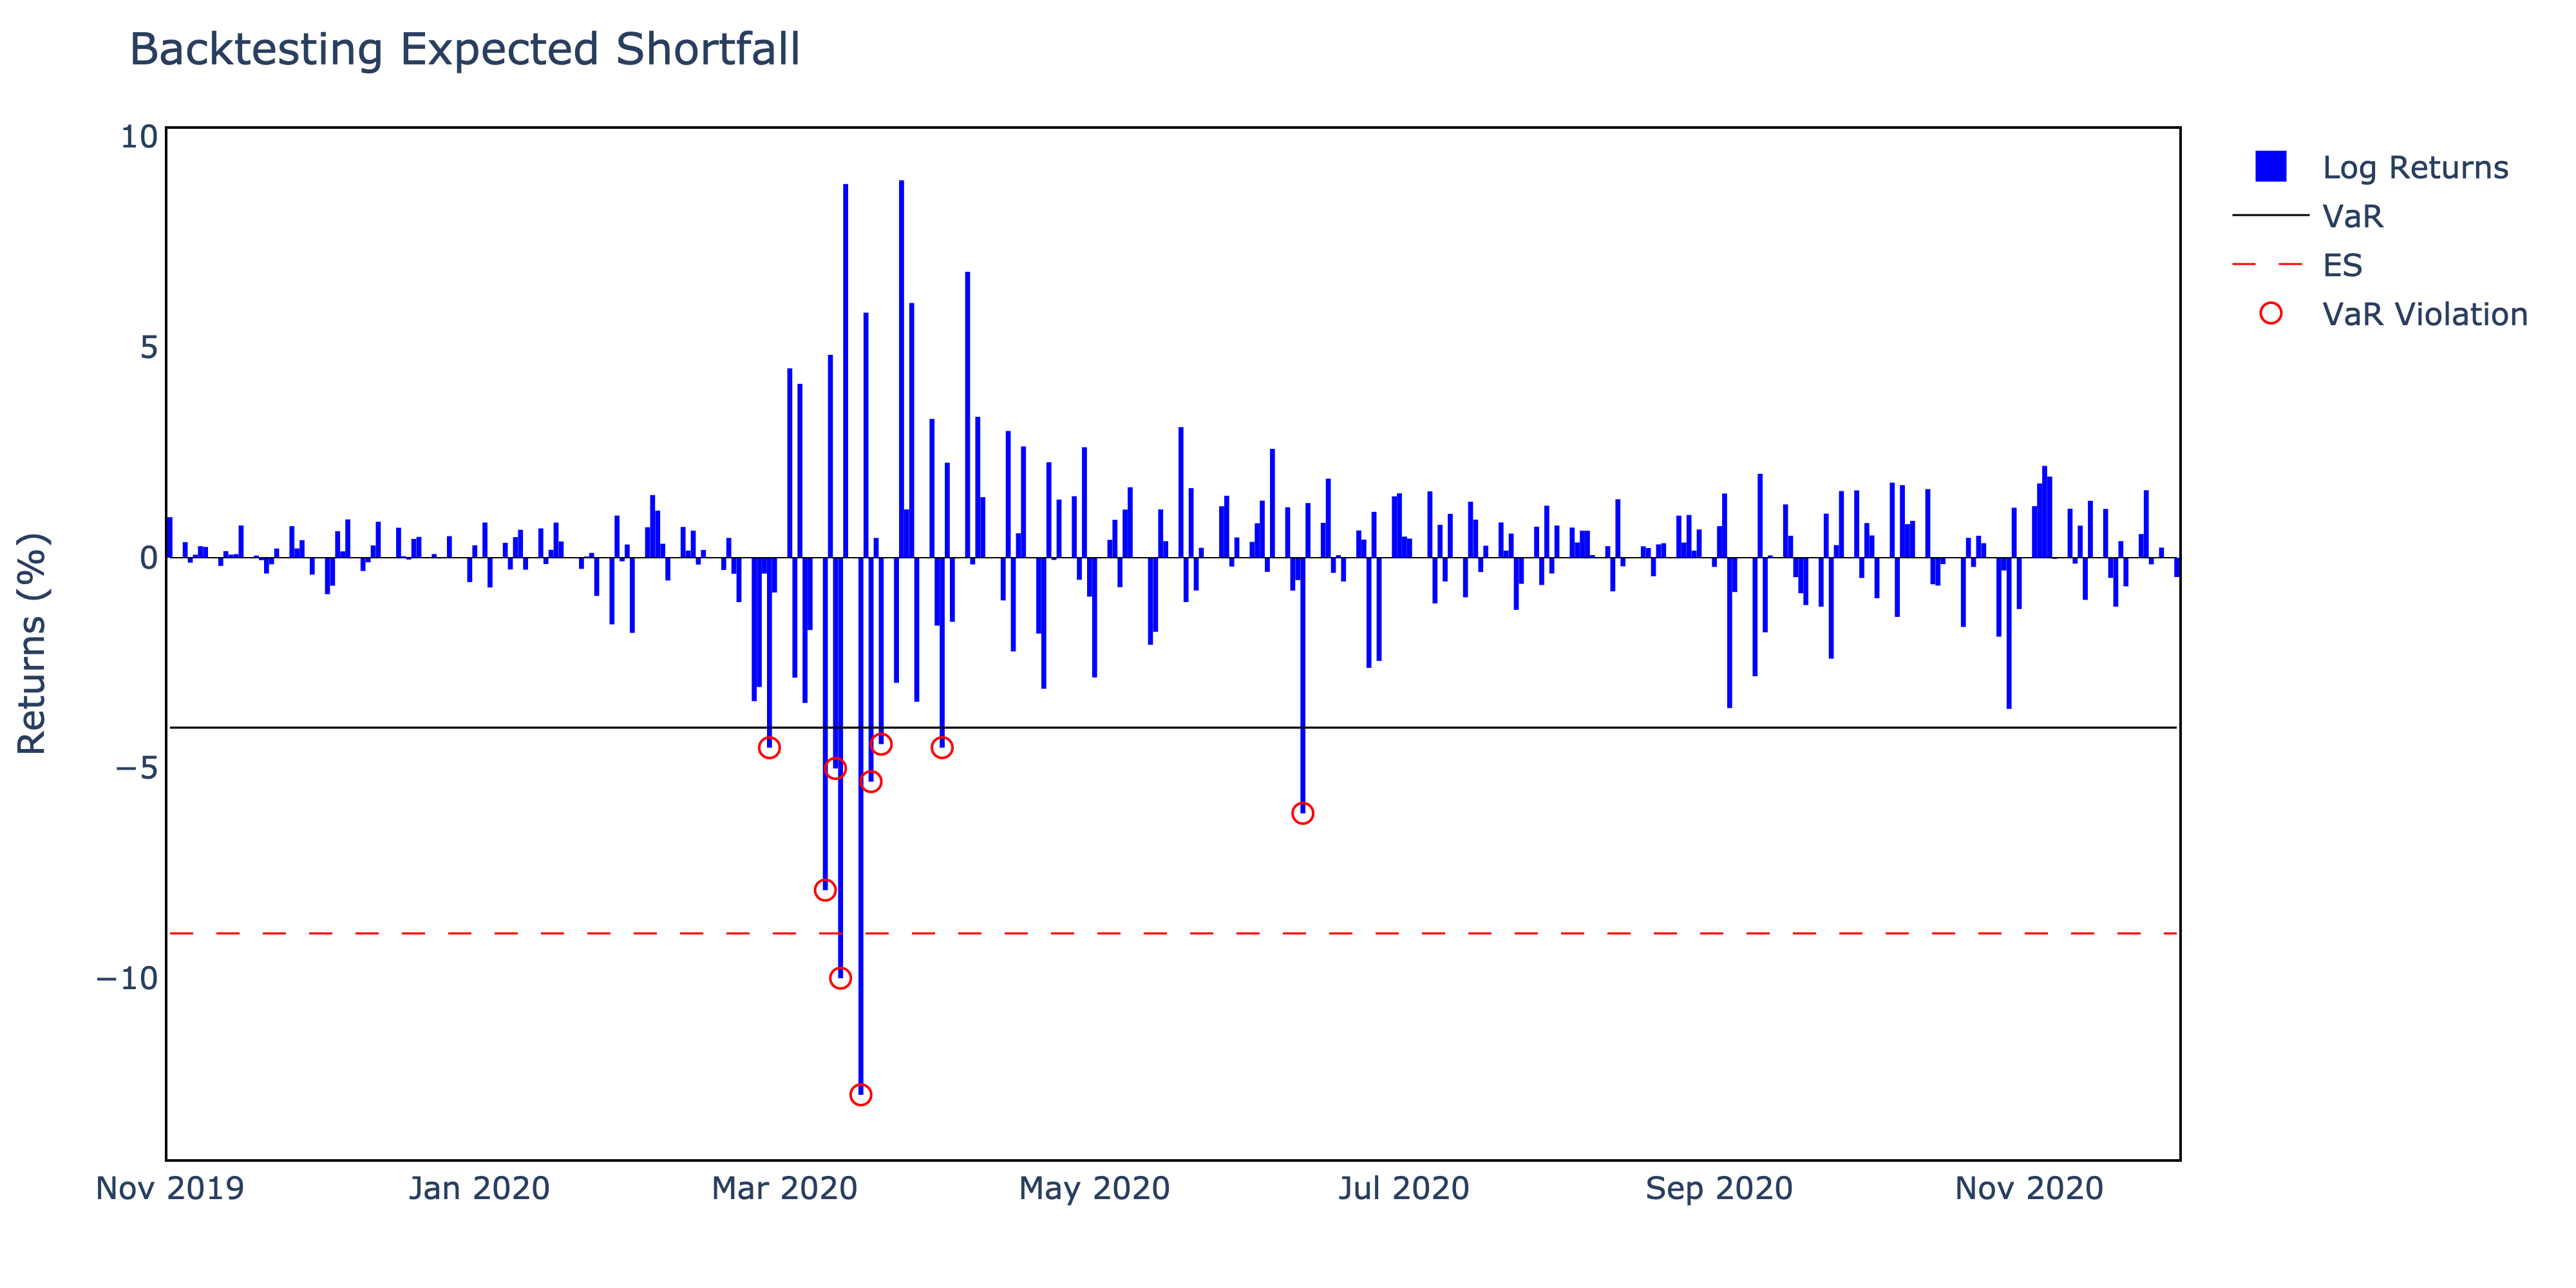

In [14]:
# Apply Parametric VaR model (choose distribution: "normal", "t", or "ged")
param_output, var = basic_var.var_parametric_iid(returns, confidence_level, distribution="t")

print(f"Parametric VaR estimate (abs): {var:.2f}%")

# Backtest full period
violations, rate = BT.backtest_var(param_output, confidence_level)
print(f"Full Period — Violations: {violations}, Rate: {rate:.2f}%")

# Compute ES for the whole period
param_output, es_estimate = ES.compute_es_parametric(param_output, returns, confidence_level, distribution="t")

print(f"Parametric ES estimate (abs): {100 * es_estimate:.2f}%")

# Plot interactive VaR
fig_var = plots.plot_var(param_output, interactive=False)

# Plot interactive ES for a subset
fig_es = plots.plot_es(param_output, subset=("2019-11-01", "2020-11-30"), interactive=False)


### Test Wealth Input

In [15]:
# Apply Parametric VaR model (choose distribution: "normal", "t", or "ged")
param_output_wealth, var_wealth = basic_var.var_parametric_iid(returns, confidence_level, distribution="t", wealth=1000000)

print(f"Parametric VaR estimate $ (abs): {var_wealth:.2f}")

param_output_wealth.head()

Parametric VaR estimate $ (abs): 40404.33


,Returns,VaR,VaR Violation,VaR_monetary
Date,,,,
2017-01-04,0.005706,0.040404,False,40404.326407
2017-01-05,-0.000771,0.040404,False,40404.326407
2017-01-06,0.003511,0.040404,False,40404.326407
2017-01-09,-0.003555,0.040404,False,40404.326407
2017-01-10,0.000000,0.040404,False,40404.326407


In [16]:
# Compute ES for the whole period
param_output_es_wealth, es_estimate_wealth = ES.compute_es_parametric(param_output, returns, confidence_level, distribution="t", wealth=1000000)

print(f"Parametric ES estimate $ (abs): {es_estimate_wealth:.2f}")

param_output_es_wealth.head()   

Parametric ES estimate $ (abs): 89298.57


,Returns,VaR,VaR Violation,ES,ES_monetary
Date,,,,,
2017-01-04,0.005706,0.040404,False,0.089299,89298.568505
2017-01-05,-0.000771,0.040404,False,0.089299,89298.568505
2017-01-06,0.003511,0.040404,False,0.089299,89298.568505
2017-01-09,-0.003555,0.040404,False,0.089299,89298.568505
2017-01-10,0.000000,0.040404,False,0.089299,89298.568505


### Appendix (DOUBLE CHECK)

#### 1. Historical Expected Shortfall (Tail Mean)  
Historical ES is the average of losses that exceed the historical VaR threshold.

$$
\text{ES} = -\mathbb{E}[r_t \mid r_t < -\text{VaR}_\alpha]
$$

#### 2. Parametric Expected Shortfall (Normal or Student-t)  
For the Normal distribution, the ES has a closed-form solution:

$$
\text{ES}_{\text{normal}} = \sigma \cdot \frac{\phi(z_\alpha)}{1 - \alpha}
$$

For the Student-t distribution with $\nu$ degrees of freedom:

$$
\text{ES}_{t} = \sigma \cdot \frac{f_{t_\nu}(t_\alpha)}{1 - \alpha} \cdot \frac{\nu + t_\alpha^2}{\nu - 1}
$$

Where:  
- $z_\alpha$ is the quantile from the standard Normal distribution  
- $t_\alpha$ is the quantile from the Student-t distribution  
- $\phi$ is the PDF of the standard Normal  
- $f_{t_\nu}$ is the PDF of the t-distribution  
- $\sigma$ is the standard deviation or scale parameter
